In [1]:

import pickle
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os

from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, RepeatVector, LSTM, Dense, Lambda, TimeDistributed
from tensorflow.keras import losses, metrics, activations
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
split = pickle.load(open('./final_data_ST_120_2019.pkl', 'rb'))['ST4000DM000']
file_list = os.listdir('./ST4000DM000')
train_list = split['train']
val_list = split['val']
test_list = split['test']
col = ['smart_7_raw', 'smart_9_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'until_fail_days']
timestep_list = [5, 10, 20, 30]

### Min-Max Scaler

In [3]:
scaler_path = './scaler_anomaly_detection.pkl'
if not os.path.isfile(scaler_path):
    scaler = MinMaxScaler()
    min_value, max_value, min_scale, max_scale = [], [], [], []
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))[col[:-1]]
        each_min = db.min(axis=0)
        each_max = db.max(axis=0)
        min_value.append(each_min)
        max_value.append(each_max)
    min_scale.append(np.array(min_value).min(axis=0))
    max_scale.append(np.array(max_value).max(axis=0))
    scaler.fit([min_scale[0], max_scale[0]])
    pickle.dump(scaler, open(scaler_path, 'wb'))
else:
    scaler = pickle.load(open(scaler_path, 'rb'))

### Data Configuration (Time_step = 120)

In [4]:
db_path = './db.pkl'
if not os.path.isfile(db_path):
    db_zip = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in time_step}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>120][col[:-1]]
        for t in time_step:
            if len(db) >= t:
                scaled_db = scaler.transform(db)
                if file_name[:-4] in train_list:
                    db_zip[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in time_step:
        db_zip[f'{t}']['train'] = np.concatenate(db_zip[f'{t}']['train'])
        db_zip[f'{t}']['val'] = np.concatenate(db_zip[f'{t}']['val'])
        db_zip[f'{t}']['test'] = np.concatenate(db_zip[f'{t}']['test'])
    pickle.dump(db_zip, open(db_path, 'wb'))
else:
    db_zip = pickle.load(open(db_path, 'rb'))

### Model Configuration

In [5]:
def flatten(X):
    '''
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return (flattened_X)

In [6]:
def lstm_ae(db, n_dimensions):
    time_step, input_dim = db.shape[1], db.shape[2]
    inputs = Input(shape=(time_step, input_dim))
    encoded = LSTM(n_dimensions, return_sequences=True, name="encoder_01")(inputs)
    encoded = LSTM(int(n_dimensions/2), return_sequences=False, name="encoder_02")(encoded)
    decoded = RepeatVector(time_step)(encoded)
    decoded = LSTM(int(input_dim/2), return_sequences=True, name='decoder_01')(decoded)
    decoded = LSTM(n_dimensions, return_sequences=True, name='decoder_02')(decoded)
    output = TimeDistributed(Dense(input_dim))(decoded)


    autoencoder = Model(inputs, output)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['cosine_proximity'])
    autoencoder.summary()
    return autoencoder

In [18]:
epoch = 500
batch_size = 128
n_dimensions = 32
time_step = 30

# for time_step in timestep_list:

callback = EarlyStopping(monitor='val_loss', patience=30, mode='min')
mc = ModelCheckpoint(f'./Model/time_step_{time_step}_batch_{batch_size}_node_{n_dimensions}.h5', monitor='val_loss', mode='min', save_best_only=True)

model = lstm_ae(db=db_zip[f'{time_step}']['train'], n_dimensions=n_dimensions)
history = model.fit(x=db_zip[f'{time_step}']['train'], y=db_zip[f'{time_step}']['train'], validation_data=[db_zip[f'{time_step}']['val'], db_zip[f'{time_step}']['val']], epochs=epoch, batch_size=batch_size, callbacks=[callback, mc])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 30, 32)            4864      
                                                                 
 encoder_02 (LSTM)           (None, 16)                3136      
                                                                 
 repeat_vector_6 (RepeatVect  (None, 30, 16)           0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 30, 2)             152       
                                                                 
 decoder_02 (LSTM)           (None, 30, 32)            4480      
                                                           

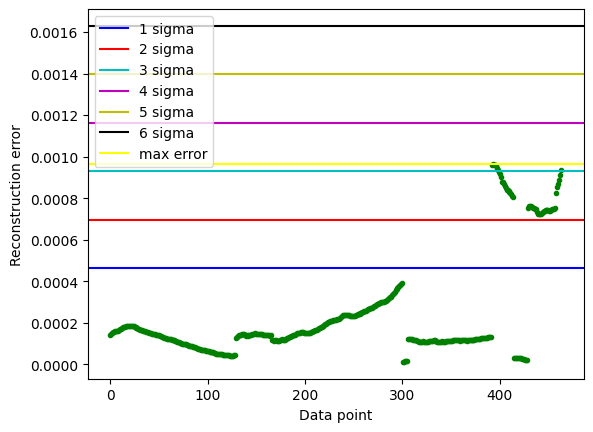

In [11]:
# timestep 5
threshold = {}
train_pred = model.predict(db_zip[f'{time_step}']['test'])
mse = np.mean(np.power(flatten(db_zip[f'{time_step}']['test']) - flatten(train_pred), 2), axis=1)
error = pd.DataFrame({'reconstruction_error': mse, })
temp = error.describe()
for sigma in range(1,7,1):
    threshold[sigma] = (temp.iloc[1].values) + (sigma * (temp.iloc[2].values))
threshold['max'] = max(mse)

plt.plot(mse, 'g.')
plt.axhline(threshold[1], color='b', label='1 sigma')
plt.axhline(threshold[2], color='r', label='2 sigma')
plt.axhline(threshold[3], color='c', label='3 sigma')
plt.axhline(threshold[4], color='m', label='4 sigma')
plt.axhline(threshold[5], color='y', label='5 sigma')
plt.axhline(threshold[6], color='k', label='6 sigma')
plt.axhline(threshold['max'], color='yellow', label='max error')

plt.xlabel('Data point')
plt.ylabel('Reconstruction error')
plt.legend()
# plt.ylim(0, 0.03)
plt.show()

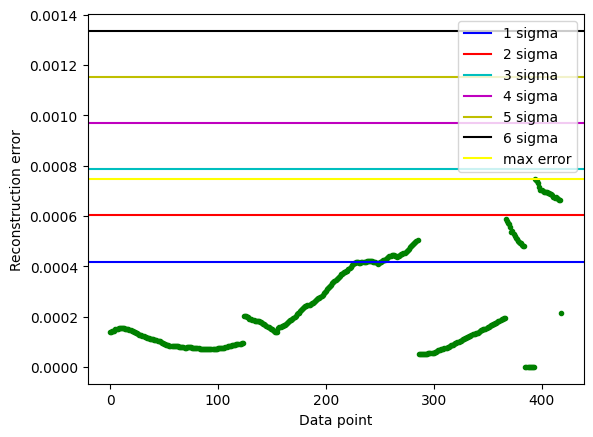

In [13]:
# timestep 10
threshold = {}
train_pred = model.predict(db_zip[f'{time_step}']['test'])
mse = np.mean(np.power(flatten(db_zip[f'{time_step}']['test']) - flatten(train_pred), 2), axis=1)
error = pd.DataFrame({'reconstruction_error': mse, })
temp = error.describe()
for sigma in range(1,7,1):
    threshold[sigma] = (temp.iloc[1].values) + (sigma * (temp.iloc[2].values))
threshold['max'] = max(mse)

plt.plot(mse, 'g.')
plt.axhline(threshold[1], color='b', label='1 sigma')
plt.axhline(threshold[2], color='r', label='2 sigma')
plt.axhline(threshold[3], color='c', label='3 sigma')
plt.axhline(threshold[4], color='m', label='4 sigma')
plt.axhline(threshold[5], color='y', label='5 sigma')
plt.axhline(threshold[6], color='k', label='6 sigma')
plt.axhline(threshold['max'], color='yellow', label='max error')

plt.xlabel('Data point')
plt.ylabel('Reconstruction error')
plt.legend()
# plt.ylim(0, 0.03)
plt.show()

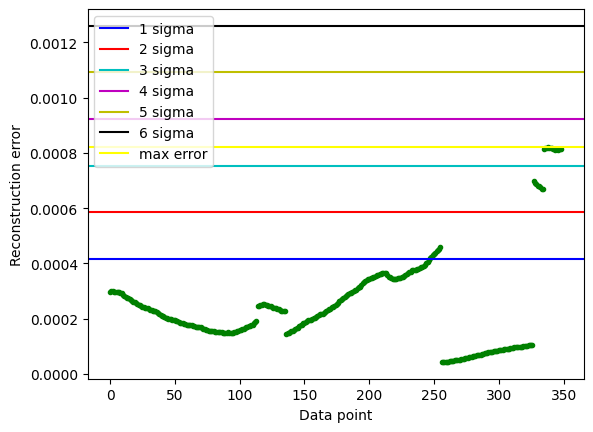

In [17]:
# timestep 20
threshold = {}
train_pred = model.predict(db_zip[f'{time_step}']['test'])
mse = np.mean(np.power(flatten(db_zip[f'{time_step}']['test']) - flatten(train_pred), 2), axis=1)
error = pd.DataFrame({'reconstruction_error': mse, })
temp = error.describe()
for sigma in range(1,7,1):
    threshold[sigma] = (temp.iloc[1].values) + (sigma * (temp.iloc[2].values))
threshold['max'] = max(mse)

plt.plot(mse, 'g.')
plt.axhline(threshold[1], color='b', label='1 sigma')
plt.axhline(threshold[2], color='r', label='2 sigma')
plt.axhline(threshold[3], color='c', label='3 sigma')
plt.axhline(threshold[4], color='m', label='4 sigma')
plt.axhline(threshold[5], color='y', label='5 sigma')
plt.axhline(threshold[6], color='k', label='6 sigma')
plt.axhline(threshold['max'], color='yellow', label='max error')

plt.xlabel('Data point')
plt.ylabel('Reconstruction error')
plt.legend()
# plt.ylim(0, 0.03)
plt.show()

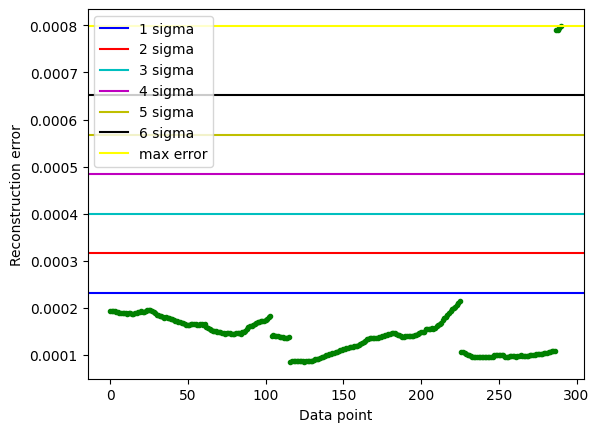

In [19]:
# timestep 30
threshold = {}
train_pred = model.predict(db_zip[f'{time_step}']['test'])
mse = np.mean(np.power(flatten(db_zip[f'{time_step}']['test']) - flatten(train_pred), 2), axis=1)
error = pd.DataFrame({'reconstruction_error': mse, })
temp = error.describe()
for sigma in range(1,7,1):
    threshold[sigma] = (temp.iloc[1].values) + (sigma * (temp.iloc[2].values))
threshold['max'] = max(mse)

plt.plot(mse, 'g.')
plt.axhline(threshold[1], color='b', label='1 sigma')
plt.axhline(threshold[2], color='r', label='2 sigma')
plt.axhline(threshold[3], color='c', label='3 sigma')
plt.axhline(threshold[4], color='m', label='4 sigma')
plt.axhline(threshold[5], color='y', label='5 sigma')
plt.axhline(threshold[6], color='k', label='6 sigma')
plt.axhline(threshold['max'], color='yellow', label='max error')

plt.xlabel('Data point')
plt.ylabel('Reconstruction error')
plt.legend()
# plt.ylim(0, 0.03)
plt.show()

In [ ]:
상원이